In [2]:
import numpy as np
import json, torch
from torch.utils.data import DataLoader
from go_metric.data_utils import *
device = torch.device('cuda:0')

In [23]:
from Bio import SeqIO
import re
prot_ids = []
seq_l = []
seq_len_l = []
for rec in SeqIO.parse("../data/uniprot_reviewed.fasta", "fasta"):
    rec.id = rec.id.split("|")[1]
    prot_ids.append(rec.id)
    seq = re.sub(r"[UZOB]", "X", str(rec.seq))
    seq_len_l.append(len(seq))
    seq = " ".join(list(seq))
    # transformers needs spaces between the amino acids
    seq_l.append(seq)

class EmbData(data.Dataset):
    def __init__(self, prot_ids, seq_l, seq_len_l):
        self.prot_ids = prot_ids
        self.seq_l = seq_l
        self.seq_len_l = seq_len_l
    def __getitem__(self, index):
        return self.prot_ids[index], self.seq_l[index], self.seq_len_l[index]
    def __len__(self):
        return len(self.prot_ids)
prot_dataset = EmbData(prot_ids, seq_l, seq_len_l)

In [29]:
bert_tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)
def seq_collator(batch):
    ids, sequences, lens = [x[0] for x in batch], [x[1] for x in batch], [x[2] for x in batch]
    inputs = bert_tokenizer.batch_encode_plus(sequences,
                                                add_special_tokens=True,
                                                padding='longest',
                                                return_attention_mask=True)
    return ids, inputs, lens
prot_loader = DataLoader(prot_dataset, collate_fn=seq_collator, batch_size=8, shuffle=False)

In [ ]:
from transformers import BertModel, BertTokenizer
import re
model = BertModel.from_pretrained("Rostlab/prot_bert_bfd")
model.to(device)
model.eval()

In [32]:
embedding_l = []
for prot_ids, tokens, seq_lens in prot_loader:
    tokenized_sequences = torch.tensor(tokens["input_ids"]).to(device)
    attention_mask = torch.tensor(tokens["attention_mask"]).to(device)
    with torch.no_grad():
        embeddings = model(
            input_ids=tokenized_sequences, attention_mask=attention_mask
        )

        embeddings = embeddings[0].cpu().numpy()
        for seq_num, seq_len in enumerate(seq_lens):
            # slice off first and last positions (special tokens)
            embedding = embeddings[seq_num][1 : seq_len + 1].mean(axis=0)
            embedding_l.append(embedding)
    if(len(embedding_l) % 1024 == 0):
        print(len(embedding_l))

1024
2048
3072
4096
5120


KeyboardInterrupt: 

In [33]:
embeddings = np.vstack(embedding_l)
print(embeddings.shape)

(5664, 1024)


In [6]:
%load_ext autoreload
%autoreload 2

/home/andrew/anaconda3/envs/research/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/andrew/anaconda3/envs/research/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


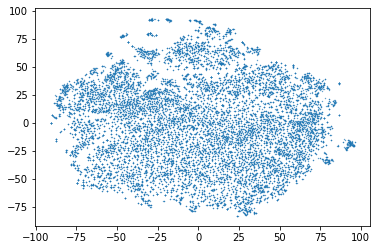

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE()
tsne = tsne.fit_transform(val_emb["embeddings"])
plt.scatter(tsne[:, 0], tsne[:, 1], s=0.1)
plt.show()

In [3]:
import pickle
with open("eval/predictions/protbert_train_emb.pkl", "rb") as f:
    train_emb = pickle.load(f)
with open("eval/predictions/protbert_val_emb.pkl", "rb") as f:
    val_emb = pickle.load(f)

from go_metric.data_utils import *
train_path = "/home/andrew/go_metric/data/go_bench"
train_dataset = BertSeqDataset.from_pickle(f"{train_path}/train.pkl")
val_dataset = BertSeqDataset.from_pickle(f"{train_path}/val.pkl")

from go_metric.multilabel_knn import embedding_knn, embedding_wknn, get_embeddings
from go_bench.metrics import threshold_stats
device = torch.device('cuda:1')

In [6]:

train_labels, val_labels = train_dataset.labels, val_dataset.labels
val_preds = embedding_knn(torch.tensor(train_emb["embeddings"]).to(device), torch.tensor(val_emb["embeddings"]).to(device), train_labels, k=2)
from go_bench.metrics import calculate_ic, ic_mat
with open(f"{train_path}/molecular_function_terms.json") as f:
    terms = json.load(f)
with open(f"{train_path}/../ic_dict.json") as f:
    ic_dict = json.load(f)
term_ic = ic_mat(terms, ic_dict)

/home/andrew/anaconda3/envs/research/lib/python3.9/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


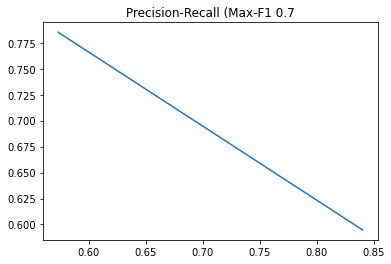

In [7]:
precs, recs, f_scores, rms, mis, rus, s_vals = threshold_stats(val_labels, val_preds, term_ic)

import matplotlib.pyplot as plt
plt.plot(precs, recs)
plt.title(f"Precision-Recall (Max-F1 {max(f_scores):,.2}")
plt.show()

In [12]:
from torch_cluster import knn
def embedding_wknn(db_emb, q_emb, db_labels, k=10):
    matches = knn(db_emb, q_emb, k).cpu().numpy() # 2 x N*K
    print("made matches", matches.shape)
    q_labels = csr_matrix((q_emb.shape[0], db_labels.shape[1]), dtype=float)
    for i in range(q_emb.shape[0]):
        if(i % 1000 == 0):
            print(f"{i/q_emb.shape[0]*100} %")
        val_res = matches[0, i*k:(i+1)*k]
        db_res = matches[1, i*k:(i+1)*k]
        dist = torch.square(db_emb[db_res] - q_emb[val_res]).sum(dim=1, keepdim=True)
        dist = (1/(1+2*dist)).cpu().numpy()
        label_res = db_labels[db_res]
        label_res = label_res.multiply(dist)
        db_avg = csr_matrix(label_res.sum(axis=0) / dist.sum())
        q_labels[i] = db_avg
    return q_labels

val_preds = embedding_wknn(torch.tensor(train_emb["embeddings"]).to(device), torch.tensor(val_emb["embeddings"]).to(device), train_labels, k=15)
precs, recs, f_scores, rms, mis, rus, s_vals = threshold_stats(val_labels, val_preds, term_ic)

plt.plot(precs, recs)
plt.title(f"Precision-Recall (Max-F1 {max(f_scores):,.2}")
plt.show()
